In [1]:
import numpy as np
import pandas as pd
import arviz as az
import numpyro
import numpyro.infer.initialization as init
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
from jax import random
from numpyro.infer import MCMC, NUTS, SVI
from numpyro.optim import Adam
from numpyro.infer.autoguide import AutoDelta, Trace_ELBO

from asteroglitch.model import Prior, Observed, Posterior

from astropy.io import ascii

from corner import corner

In [2]:
data = ascii.read('legacy_sample.dat')

In [3]:
data[:5]

KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
,,,uHz,uHz,uHz,ppm,ppm,ppm,uHz,uHz,uHz,,dex(---)
str8,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64
1435467,11,1,889.2462,0.4684,0.5275,--,--,--,--,--,--,>,6.0
1435467,11,2,920.04359,1.82491,1.99226,--,--,--,--,--,--,--,-0.43
1435467,12,0,928.21507,0.93861,0.71004,2.39354,0.13859,0.13474,4.78553,0.56621,0.96263,--,2.11
1435467,12,1,957.0404,0.49553,0.45874,--,--,--,--,--,--,>,6.0
1435467,12,2,989.14249,1.23662,1.29837,--,--,--,--,--,--,--,1.63


In [26]:
kic = "1435467"
mask = (data["KIC"] == kic) & (data["l"] == 0)
data[mask]

KIC,n,l,Freq,e_Freq,E_Freq,Amp,e_Amp,E_Amp,Width,e_Width,E_Width,l_lnK,lnK
,,,uHz,uHz,uHz,ppm,ppm,ppm,uHz,uHz,uHz,,dex(---)
str8,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str1,float64
1435467,12,0,928.21507,0.93861,0.71004,2.39354,0.13859,0.13474,4.78553,0.56621,0.96263,--,2.11
1435467,13,0,995.1282,0.42971,0.53104,2.42667,0.17855,0.12309,4.57011,0.7475,0.71635,>,6.0
1435467,14,0,1064.42275,0.3405,0.36169,2.67247,0.17882,0.12735,3.67689,0.53474,0.97238,>,6.0
1435467,15,0,1136.15266,0.33825,0.38756,3.41069,0.14151,0.17474,5.04977,0.70109,1.1473,>,6.0
1435467,16,0,1206.55225,0.20615,0.23525,3.61395,0.14318,0.1563,3.91196,0.59702,0.61436,>,6.0
1435467,17,0,1275.25231,0.29437,0.31292,4.53579,0.15417,0.14946,5.87896,0.62454,0.51971,>,6.0
1435467,18,0,1343.82352,0.35083,0.30581,4.55438,0.1326,0.17259,5.32421,0.5327,0.45294,>,6.0
1435467,19,0,1414.65637,0.17913,0.1869,4.20091,0.11965,0.18534,3.59444,0.3601,0.47502,>,6.0


In [27]:
n = jnp.array(data[mask]["n"])
nu_obs = jnp.array(data[mask]["Freq"])
nu_err = jnp.maximum(data[mask]["e_Freq"], data[mask]["E_Freq"])

In [28]:
glob = ascii.read('legacy_globals.dat')
glob[glob["KIC"] == kic]

KIC,Name,Kpmag,numax,Dnu,N,Cat,BkQ,MgQ,Teff,e_Teff,r_Teff,[Fe/H],e_[Fe/H],r_[Fe/H],logg,e_logg,E_logg,Vlos,e_Vlos,vsini,e_vsini
,,mag,uHz,uHz,,,,,K,K,,dex(---),dex(---),,dex(cm / s2),dex(cm / s2),dex(cm / s2),km / s,km / s,km / s,km / s
str8,str9,float64,int64,float64,int64,str6,str8,str18,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1435467,--,8.88,1407,70.4,46,F-like,5.1-17.2,--,6326,77,--,0.01,0.1,--,4.1,0.009,0.009,-66.52,0.1,11.9,0.5


In [29]:
delta_nu = [glob[glob["KIC"] == kic]['Dnu'][0]]
delta_nu.append(0.01*delta_nu[-1])
print(delta_nu)

nu_max = [glob[glob["KIC"] == kic]['numax'][0]]
nu_max.append(0.05*delta_nu[-1])
print(nu_max)

[70.4, 0.7040000000000001]
[1407, 0.0352]


In [30]:
epsilon = [1.3, 0.2]
alpha = [np.log(0.001), 1.0]

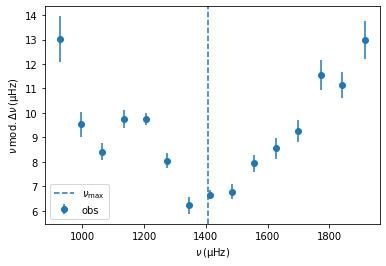

In [31]:
nu_mod = nu_obs % delta_nu[0]

fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_mod, yerr=nu_err, fmt='o', label='obs')

ax.axvline(nu_max[0], linestyle='--', label=r'$\nu_\mathrm{max}$')
ax.set_ylabel(r'$\nu\,\mathrm{mod.}\Delta\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()

In [32]:
prior = Prior(delta_nu, nu_max, epsilon, alpha, n=n)

In [33]:
init_strategy = lambda site=None: init.init_to_median(site=site, num_samples=1000)

In [34]:
num_warmup, num_samples, num_chains = 2000, 2000, 4

rng_key = random.PRNGKey(0)

kernel = NUTS(prior.model, target_accept_prob=0.99, init_strategy=init_strategy)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [35]:
mcmc.run(rng_key)
mcmc.print_summary()

/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:1010: UserWarning: Continuous inference poorly handles circular sample site 'phi_he'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_he': CircularReparam()}).
  warnings.warn(msg, UserWarning)
/Users/ajl573/Repos/alexlyttle/numpyro/numpyro/infer/util.py:1010: UserWarning: Continuous inference poorly handles circular sample site 'phi_cz'. Consider using VonMises distribution together with a reparameterizer, e.g. numpyro.handlers.reparam(config={'phi_cz': CircularReparam()}).
  warnings.warn(msg, UserWarning)


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      alpha      0.00      0.00      0.00      0.00      0.00   6602.87      1.00
         b0      0.06      0.08      0.04      0.00      0.13   6586.37      1.00
         b1      0.00      0.00      0.00      0.00      0.00   6229.60      1.00
         c0 1623048.69 2102517.77 989222.97  29546.28 3568324.56   6478.42      1.00
   delta_nu     70.41      0.69     70.40     69.29     71.56   9151.38      1.00
  delta_tau      0.00      0.00      0.00      0.00      0.00   7502.36      1.00
    epsilon      1.30      0.20      1.30      0.97      1.62   8571.79      1.00
     nu_err      0.08      0.06      0.07      0.00      0.17  10169.75      1.00
     nu_max   1407.00      0.03   1407.00   1406.94   1407.05   9202.89      1.00
     phi_cz     -0.01      1.72     -0.01     -2.62      2.89  10227.34      1.00
     phi_he      0.01      1.75      0.04     -2.57      2.94   9582.82      1.00
     tau_he 

In [36]:
trace_prior = az.from_dict(
    posterior=mcmc.get_samples(group_by_chain=True),
    sample_stats=mcmc.get_extra_fields(group_by_chain=True),
)

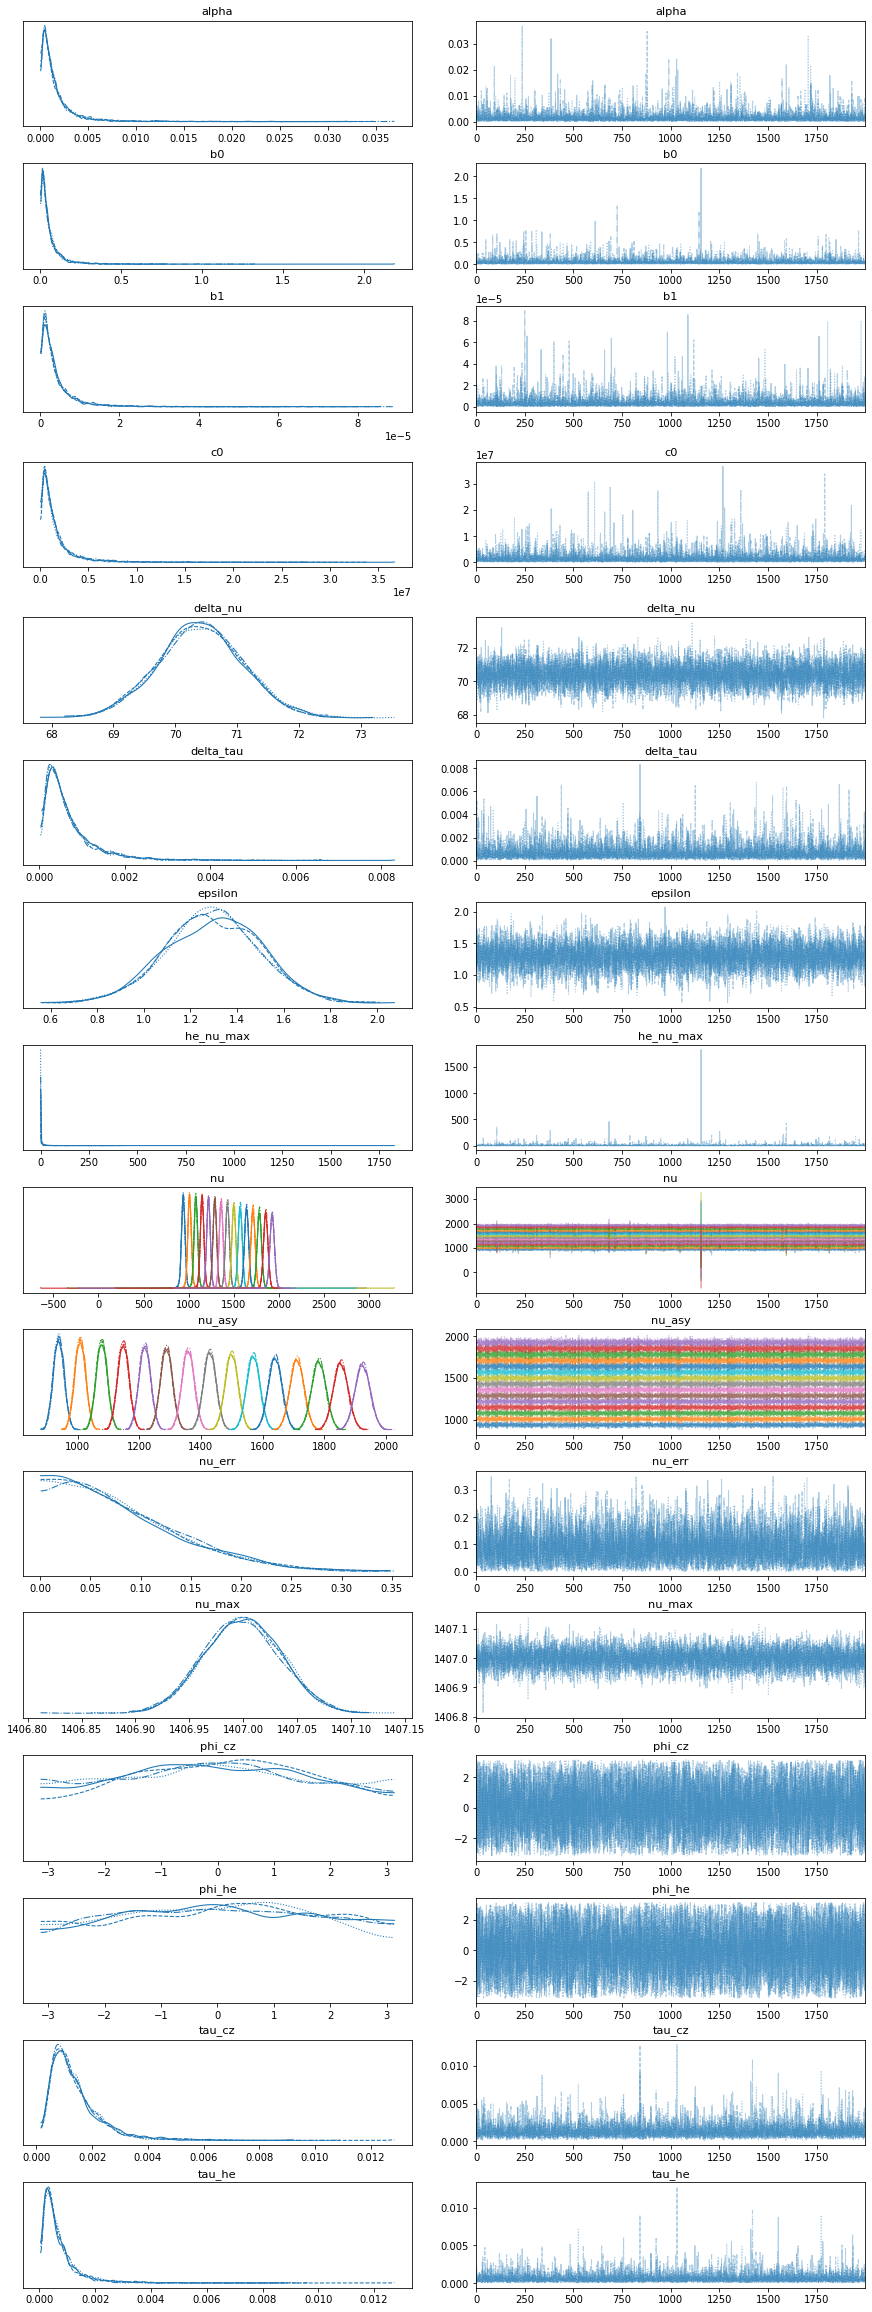

In [37]:
az.plot_trace(trace_prior);

In [38]:
observed = Observed(nu_obs, nu_err=nu_err)

In [39]:
posterior = Posterior(prior, observed)

In [40]:
# model = jax.pmap(posterior.model)
model = posterior.model

In [41]:
optimizer = Adam(step_size=0.005)
loss = Trace_ELBO()

guide = AutoDelta(model, init_loc_fn=init_strategy)
svi = SVI(model, guide, optimizer, loss)

In [42]:
svi_result = svi.run(random.PRNGKey(0), 10000)

100%|██████████| 10000/10000 [00:04<00:00, 2276.37it/s, init loss: 11418.5753, avg. loss [9501-10000]: -6.1065]


In [43]:
svi_result.params

{'alpha_auto_loc': DeviceArray(0.00409476, dtype=float64),
 'b0_auto_loc': DeviceArray(0.01346246, dtype=float64),
 'b1_auto_loc': DeviceArray(2.13290635e-06, dtype=float64),
 'c0_auto_loc': DeviceArray(1806947.29093874, dtype=float64),
 'delta_nu_auto_loc': DeviceArray(70.29637447, dtype=float64),
 'delta_tau_auto_loc': DeviceArray(0.00065942, dtype=float64),
 'epsilon_auto_loc': DeviceArray(1.13030556, dtype=float64),
 'nu_err_auto_loc': DeviceArray(0.02781037, dtype=float64),
 'nu_max_auto_loc': DeviceArray(1406.99999433, dtype=float64),
 'phi_cz_unwrapped_auto_loc': DeviceArray(-4.21629612, dtype=float64),
 'phi_he_unwrapped_auto_loc': DeviceArray(-2.58949782, dtype=float64),
 'tau_he_auto_loc': DeviceArray(0.00055002, dtype=float64)}

In [50]:
num_warmup, num_samples, num_chains = 2000, 2000, 4

rng_key = random.PRNGKey(53)

kernel = NUTS(model, target_accept_prob=0.99, init_strategy=init_strategy, dense_mass=True)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)

In [51]:
init_params = {k[:k.find('_auto_loc')]: v for k, v in svi_result.params.items()}

In [52]:
init_params_batched = jax.tree_map(lambda x: jnp.broadcast_to(x, (num_chains,)), init_params)

In [53]:
# mcmc.warmup(rng_key, collect_warmup=True, init_params=init_params_batched)

In [54]:
%%time
mcmc.run(
    rng_key, 
#     init_params=init_params_batched
)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

CPU times: user 2min 15s, sys: 808 ms, total: 2min 15s
Wall time: 54.1 s


In [55]:
mcmc.print_summary()


                        mean       std    median      5.0%     95.0%     n_eff     r_hat
             alpha      0.00      0.00      0.00      0.00      0.00    526.60      1.02
                b0      0.02      0.03      0.02      0.00      0.04    905.83      1.01
                b1      0.00      0.00      0.00      0.00      0.00    140.47      1.02
                c0 778573.12 546444.74 608430.68  88955.33 1723483.80    161.78      1.02
          delta_nu     70.38      0.04     70.38     70.32     70.45    641.02      1.01
         delta_tau      0.00      0.00      0.00      0.00      0.00    430.97      1.01
           epsilon      1.11      0.01      1.11      1.09      1.12    648.56      1.01
            nu_err      0.08      0.07      0.07      0.00      0.18    403.01      1.01
            nu_max   1407.00      0.03   1407.00   1406.95   1407.05   1074.65      1.01
  phi_cz_unwrapped    260.34    295.79    179.42    -65.79    675.75      3.17      2.76
  phi_he_unwrapped 

In [56]:
group_by_chain = True
samples = mcmc.get_samples(group_by_chain=group_by_chain)
sample_stats = mcmc.get_extra_fields(group_by_chain=group_by_chain)

In [57]:
trace = az.from_dict(posterior=samples, sample_stats=sample_stats)

In [83]:
0.5*prior.nu_max[0]**2

989824.5

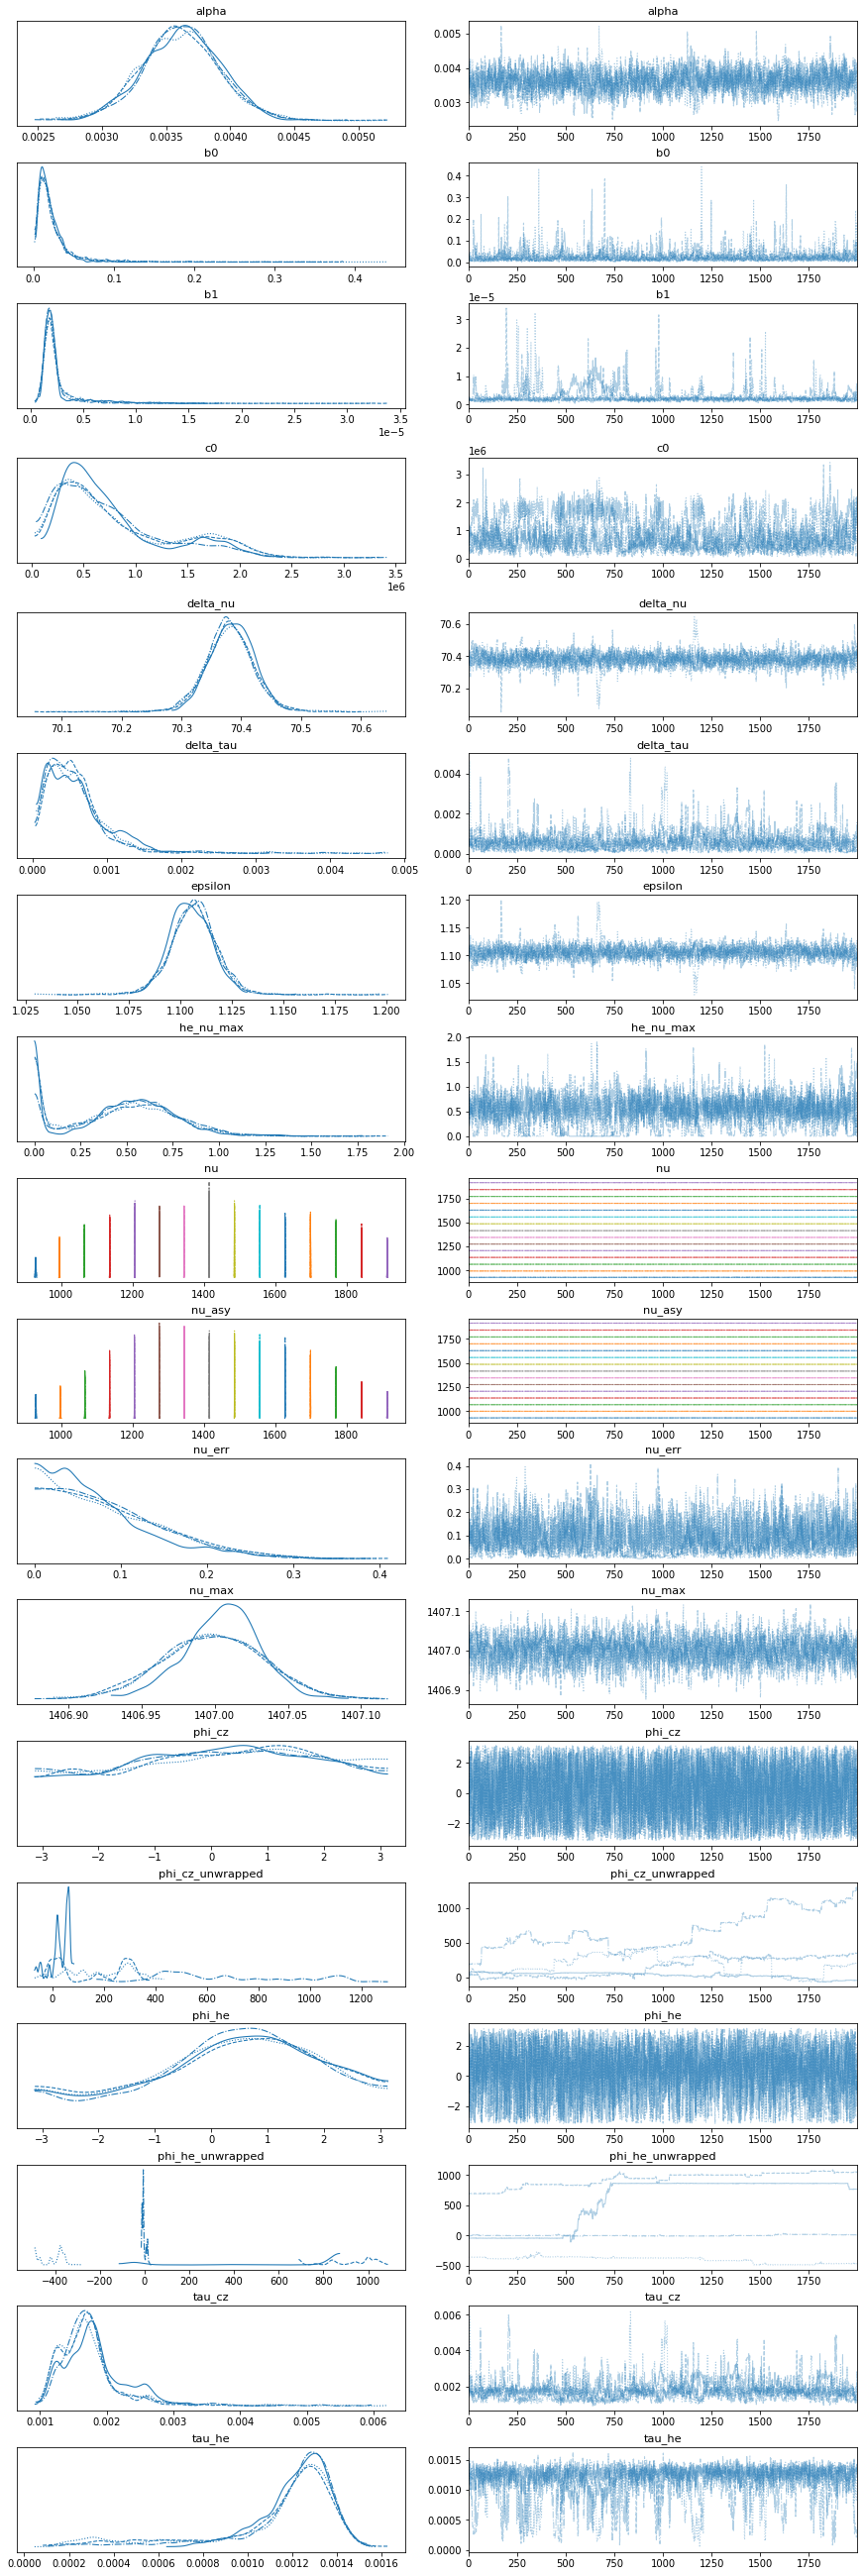

In [58]:
az.plot_trace(trace);

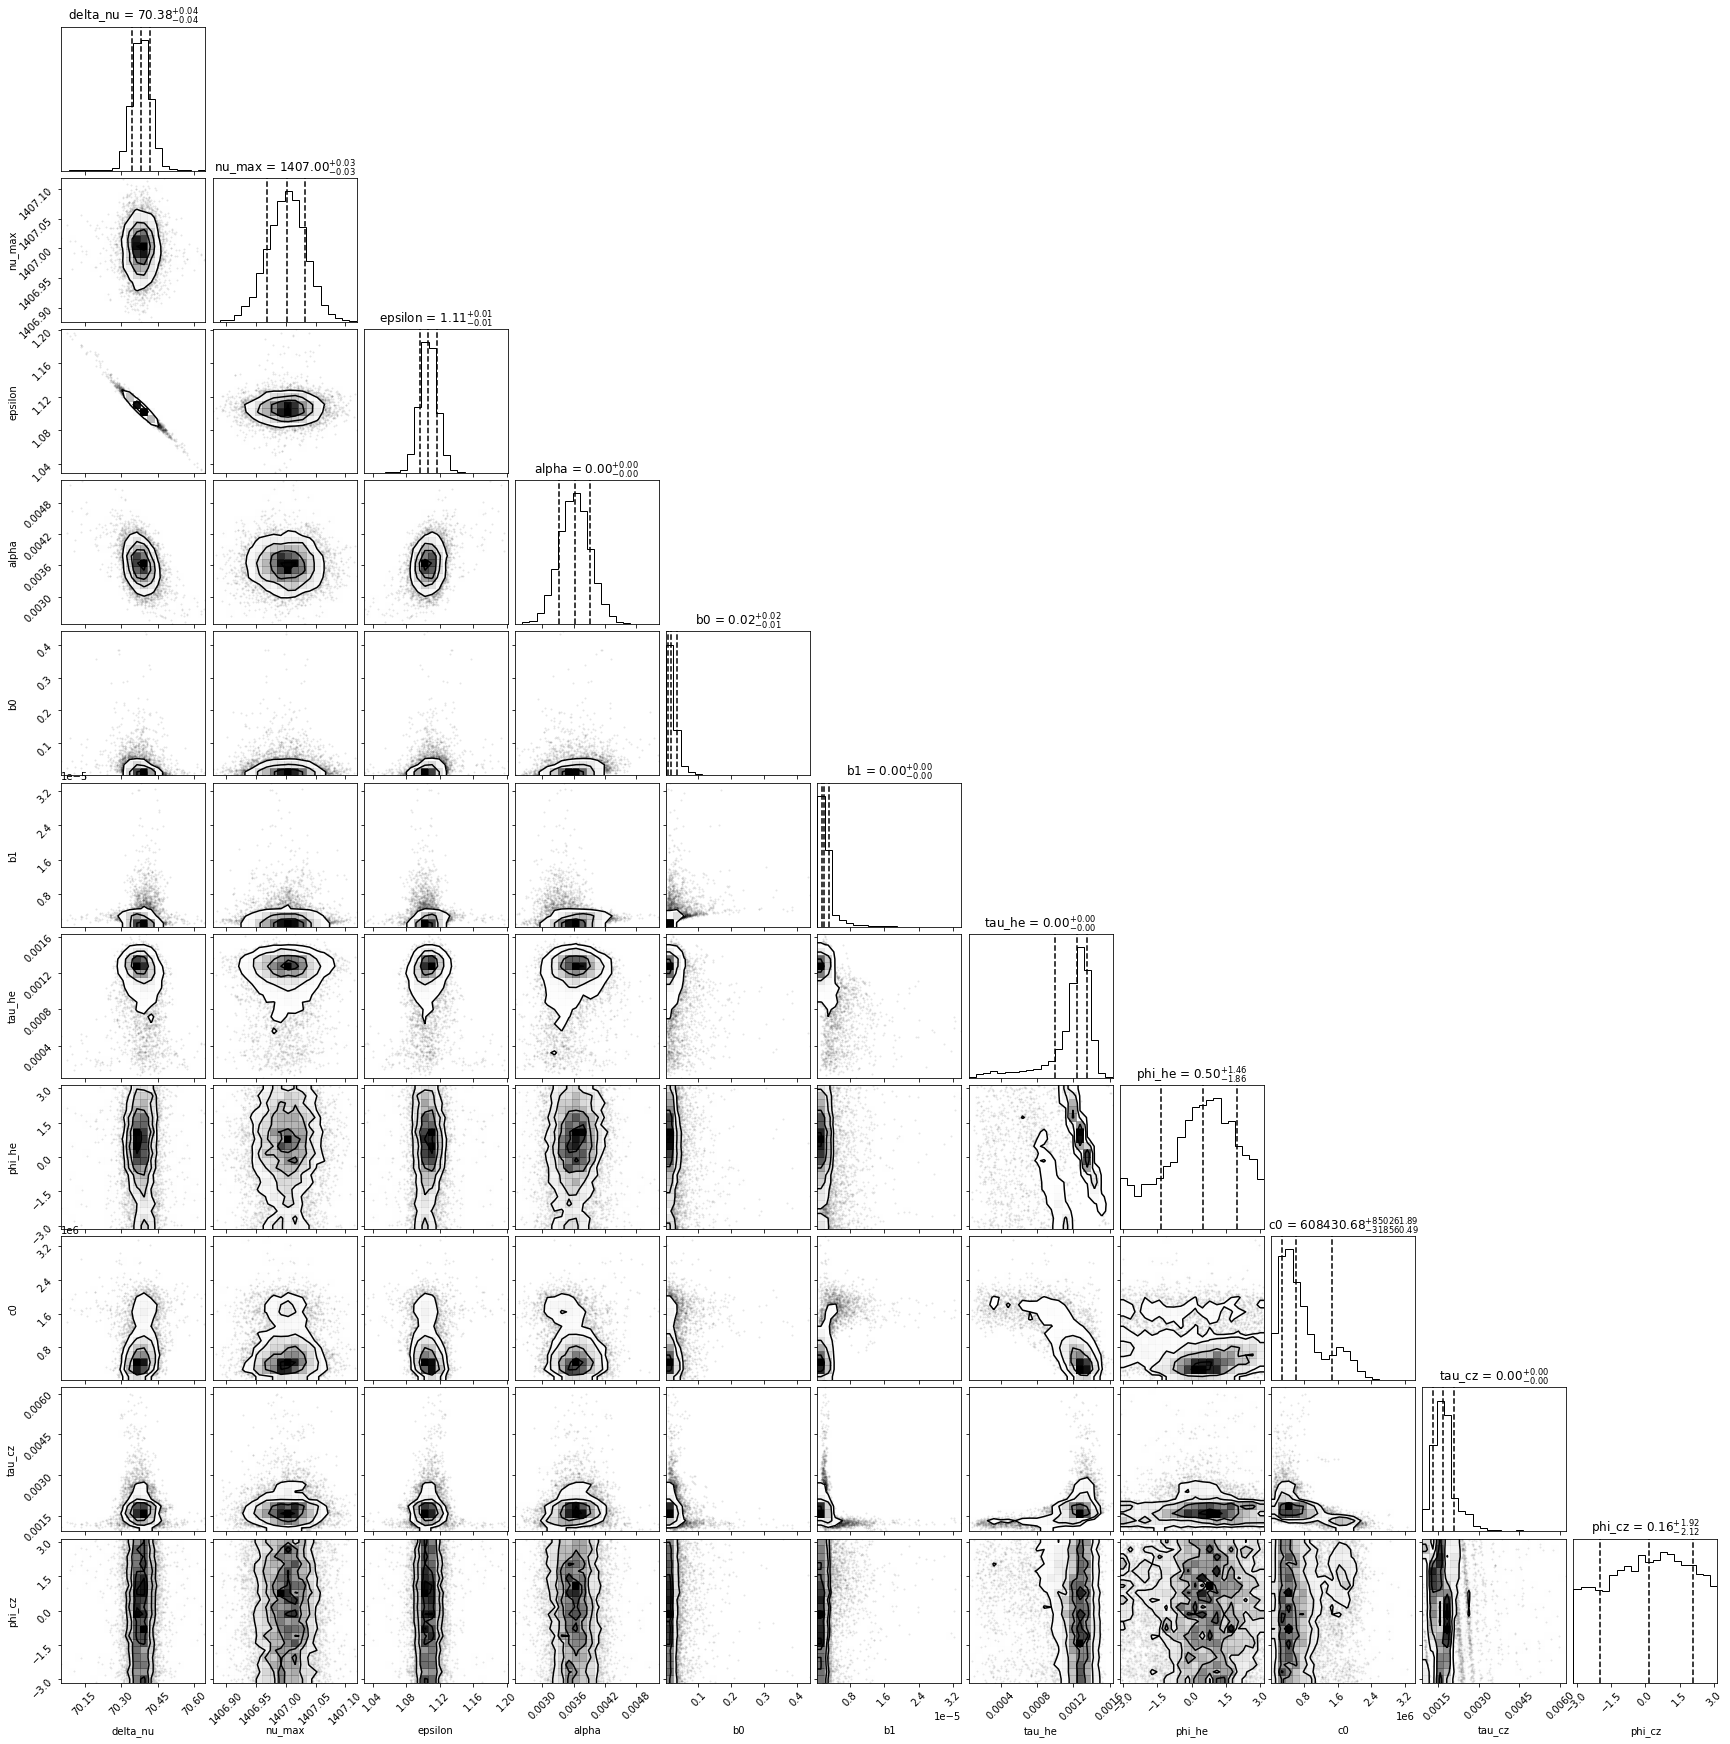

In [59]:
corner(
    trace, 
    var_names=['delta_nu', 'nu_max', 'epsilon', 'alpha', 
               'b0', 'b1', 'tau_he', 'phi_he', 'c0', 'tau_cz', 'phi_cz'], 
    divergences=True,
    divergences_kwargs={'color': 'r', 'alpha': 0.9, 'markersize': 4},
    quantiles=[.16, .5, .84],
    show_titles=True,
);

In [62]:
samples = mcmc.get_samples()

In [66]:
from asteroglitch.model import asy_background, he_glitch, cz_glitch

In [67]:
n_points = 500
nu_fit = np.linspace(nu_obs[0], nu_obs[-1], n_points)
n_fit = np.linspace(n[0], n[-1], n_points)

asy_fit = asy_background(n_fit[:, jnp.newaxis], samples['epsilon'], 
                     samples['alpha'], samples['delta_nu'], samples['nu_max'])

he_glitch_fit = he_glitch(nu_fit[:, jnp.newaxis], samples['b0'], 
                          samples['b1'], samples['tau_he'], samples['phi_he'])
cz_glitch_fit = cz_glitch(nu_fit[:, jnp.newaxis], samples['c0'], 
                          samples['tau_cz'], samples['phi_cz'])

In [68]:
glitch_fit = he_glitch_fit + cz_glitch_fit

In [70]:
glitch_upper = np.quantile(glitch_fit, .84, axis=1)
glitch_median = np.median(glitch_fit, axis=1)
glitch_lower = np.quantile(glitch_fit, .16, axis=1)

In [71]:
asy_med = np.median(samples['nu_asy'], axis=0)
asy_err = [asy_med - np.quantile(samples['nu_asy'], .16, axis=0),  # lower
           np.quantile(samples['nu_asy'], .84, axis=0) - asy_med]  # upper

In [80]:
err = [np.sqrt(e**2 + nu_err**2) for e in asy_err]

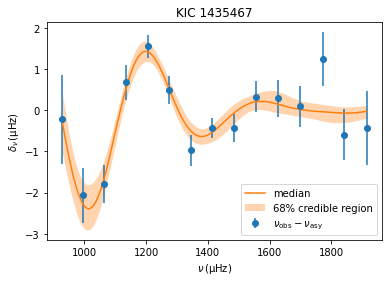

In [81]:
fig, ax = plt.subplots()

ax.errorbar(nu_obs, nu_obs - asy_med, yerr=err[::-1], fmt='o', label=r'$\nu_\mathrm{obs} - \nu_\mathrm{asy}$')

ax.plot(nu_fit, glitch_median, '-', color='C1', label='median')
ax.fill_between(nu_fit, glitch_lower, glitch_upper, color='C1', alpha=0.33, linewidth=0, label='68% credible region')

ax.set_ylabel(r'$\delta_\nu\,(\mathrm{\mu Hz})$')
ax.set_xlabel(r'$\nu\,(\mathrm{\mu Hz})$')

ax.legend()
ax.set_title(f'KIC {kic}');

In [ ]:
# Highest mass, highest FeH in grid and look at profile and look for 
# heII glitch by eye and compare with base of convective zone
# Model profiles for grid2p5 (larger mass range)

In [82]:
glob

KIC,Name,Kpmag,numax,Dnu,N,Cat,BkQ,MgQ,Teff,e_Teff,r_Teff,[Fe/H],e_[Fe/H],r_[Fe/H],logg,e_logg,E_logg,Vlos,e_Vlos,vsini,e_vsini
,,mag,uHz,uHz,,,,,K,K,,dex(---),dex(---),,dex(cm / s2),dex(cm / s2),dex(cm / s2),km / s,km / s,km / s,km / s
str8,str9,float64,int64,float64,int64,str6,str8,str18,int64,int64,int64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64
1435467,--,8.88,1407,70.4,46,F-like,5.1-17.2,--,6326,77,--,0.01,0.1,--,4.1,0.009,0.009,-66.52,0.1,11.9,0.5
2837475,--,8.48,1558,75.7,54,F-like,5.1-17.2,--,6614,77,--,0.01,0.1,--,4.163,0.007,0.007,-13.28,0.1,23.3,0.5
3427720,--,9.11,2737,120.1,36,Simple,5.1-17.2,--,6045,77,--,-0.06,0.1,--,4.387,0.005,0.004,-22.91,0.1,2.9,0.5
3456181,--,9.66,970,52.3,45,F-like,5.1-11.3,"6, 10",6384,77,--,-0.15,0.1,--,3.95,0.007,0.005,-50.12,0.1,8.5,0.5
3632418,Cassie,8.22,1167,60.7,54,F-like,5.1-17.2,--,6193,77,--,-0.12,0.1,--,4.024,0.007,0.005,-19.11,0.1,8.5,0.5
3656476,Java,9.52,1925,93.2,38,Simple,5.1-17.2,"6, 10, 14",5668,77,--,0.25,0.1,--,4.225,0.008,0.01,-13.29,0.1,2.3,0.5
3735871,--,9.71,2863,123.0,34,Simple,5.1-17.2,--,6107,77,--,-0.04,0.1,--,4.396,0.007,0.007,6.9,0.1,4.8,0.5
4914923,Vitto,9.46,1817,88.5,38,Simple,5.1-17.2,6,5805,77,--,0.08,0.1,--,4.197,0.008,0.01,-39.16,0.1,3.4,0.5
